In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def percentile_envelope(Y, p_lo=16, p_hi=84, axis=0):
    lo  = np.percentile(Y, p_lo, axis=axis)
    med = np.percentile(Y, 50,   axis=axis)
    hi  = np.percentile(Y, p_hi, axis=axis)
    return lo, med, hi


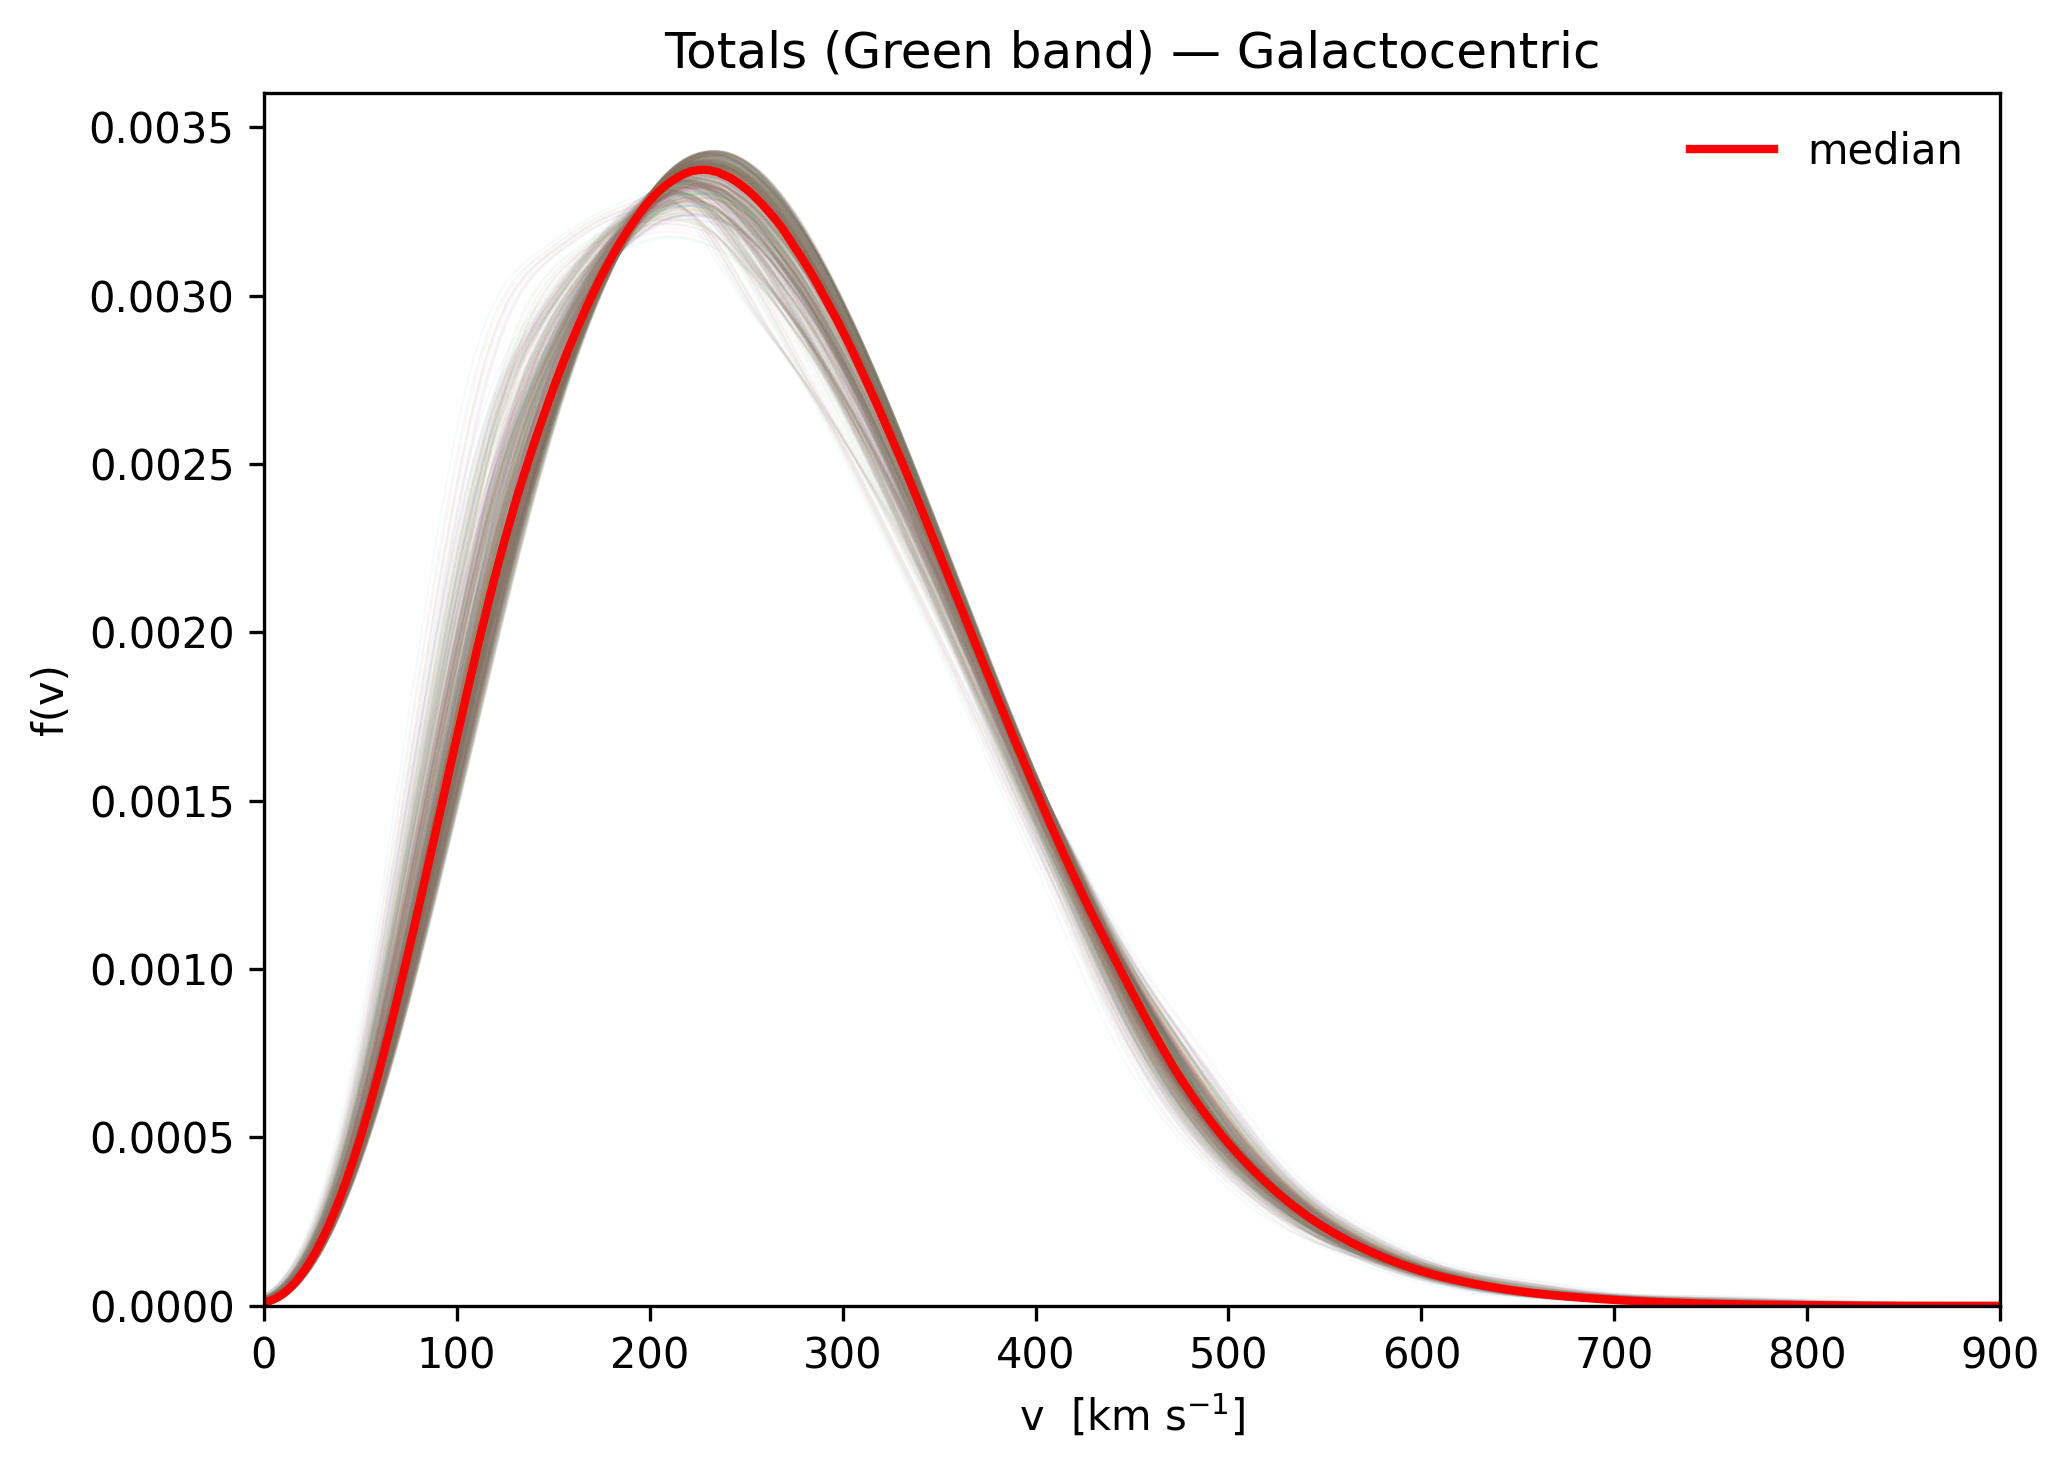

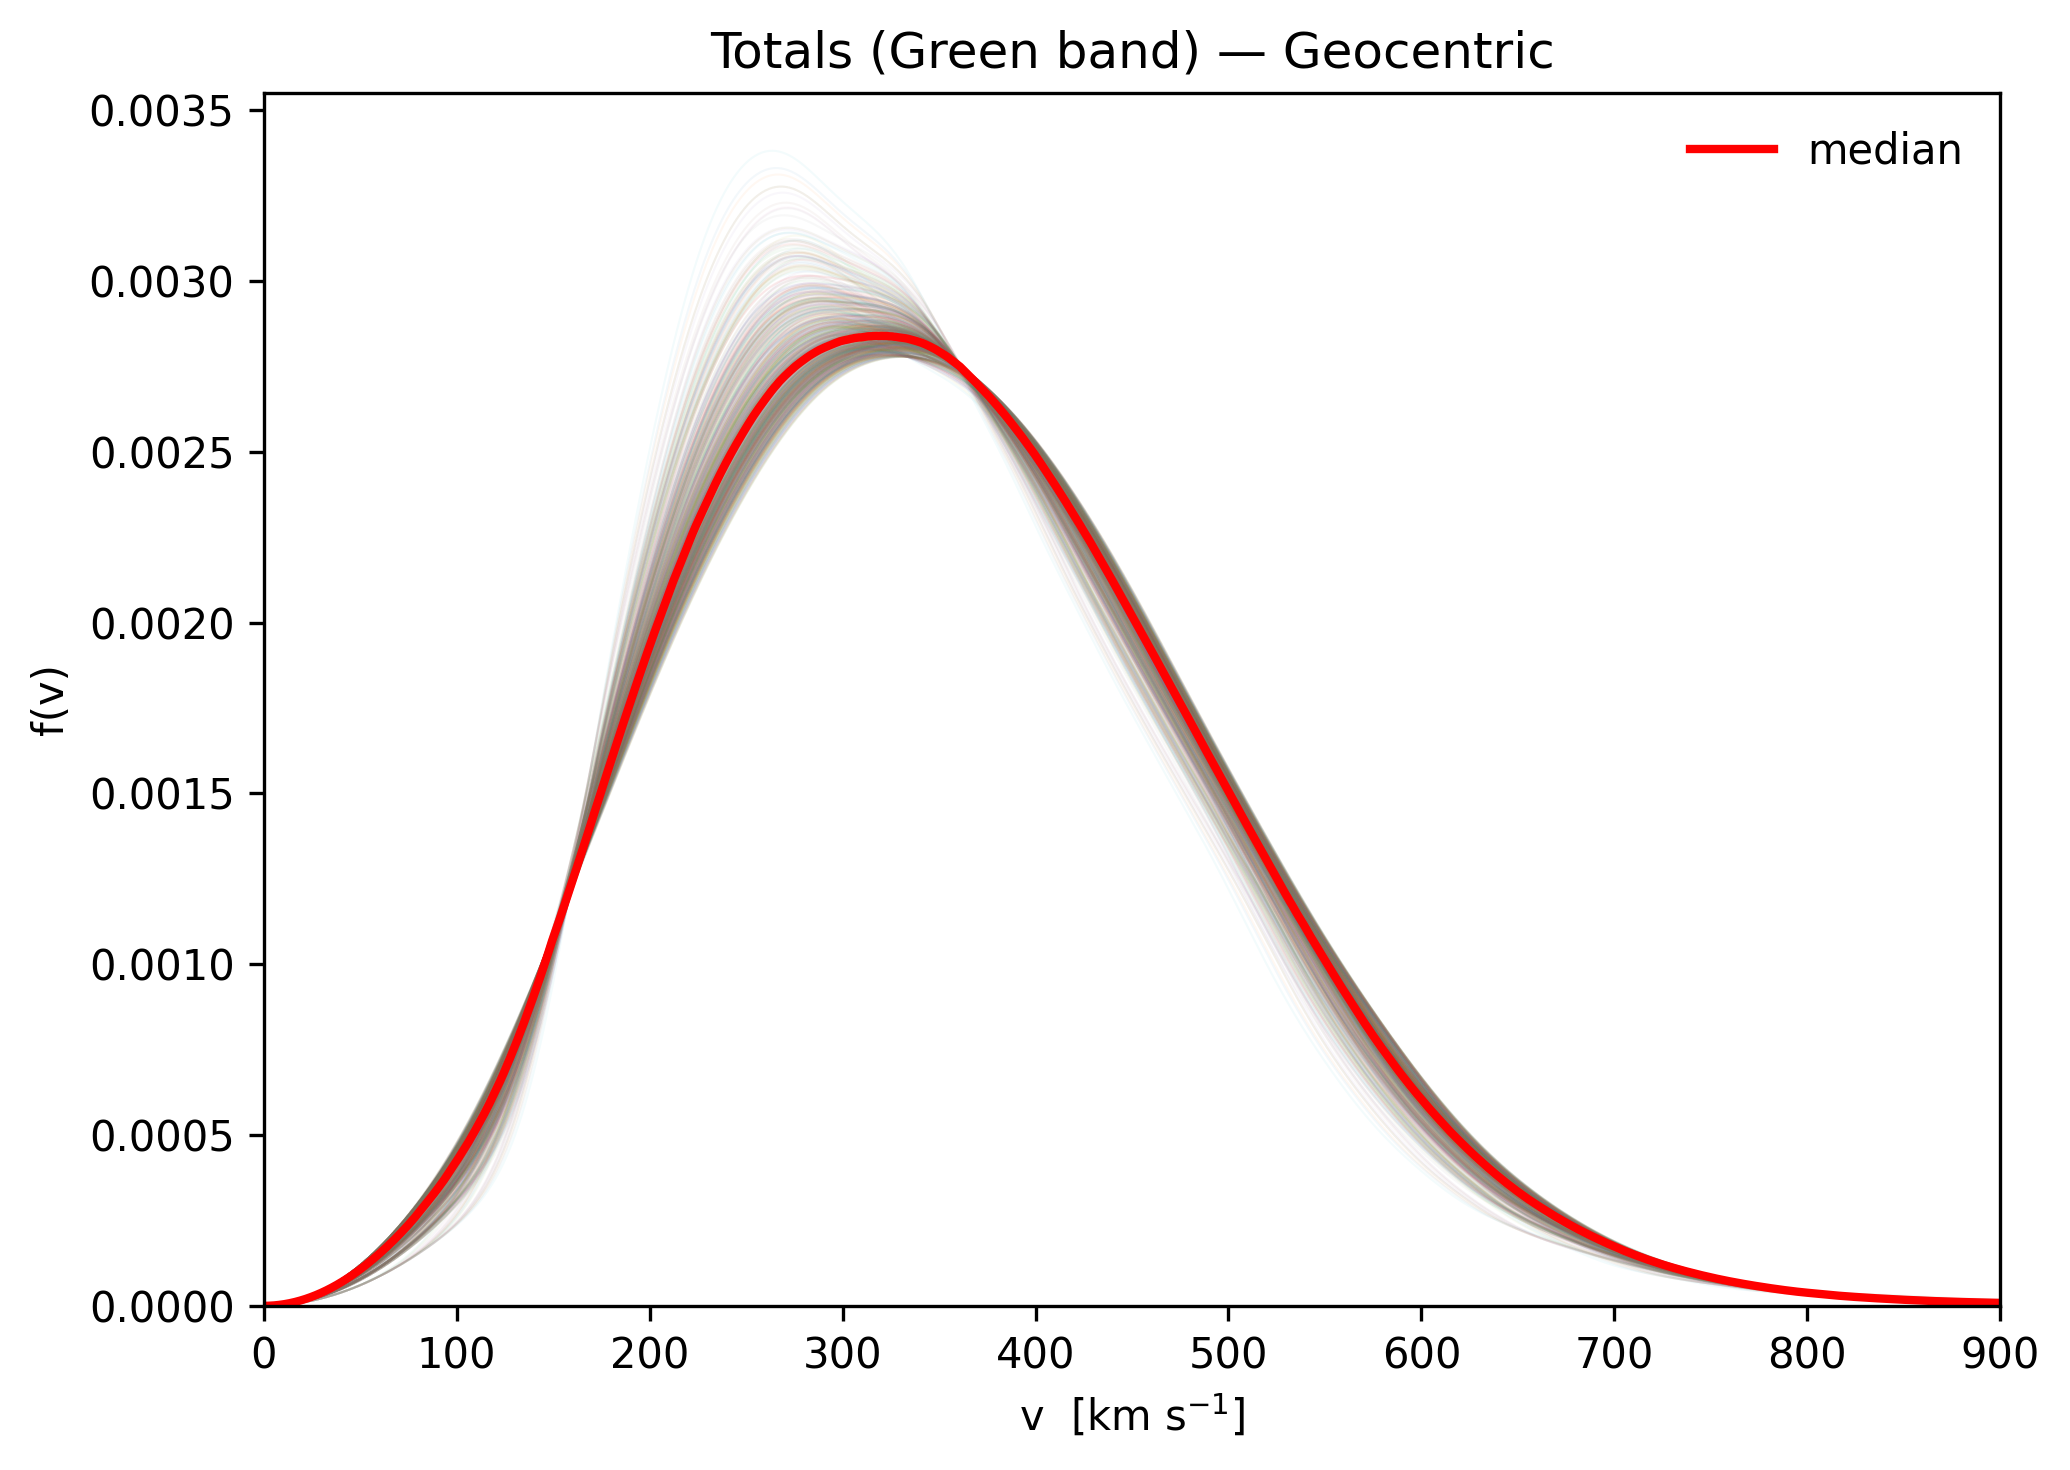

In [4]:
# Change paths if your files live elsewhere
TOTAL_GAL = "total_galactocentric.csv"
TOTAL_GEO = "total_geocentric.csv"

def load_totals(path):
    df = pd.read_csv(path)
    v = df["v"].to_numpy(float)
    cols = [c for c in df.columns if c != "v"]          # f_* columns
    Y = df[cols].to_numpy(float).T                      # [n_curves, Nv]
    return v, Y, cols

def plot_total_fs(v, Y, title):
    fig, ax = plt.subplots(figsize=(7,5), dpi=300)
    for y in Y:
        ax.plot(v, y, lw=0.5, alpha=0.05)
    lo, med, hi = percentile_envelope(Y, 16, 84, axis=0)
    # ax.fill_between(v, lo, hi, alpha=0.2, lw=0, label="16–84%")
    ax.plot(v, med, lw=2.0, label="median", color='red')
    ax.set_xlim(v.min(), v.max())
    ax.set_ylim(bottom=0)
    ax.set_xlabel(r"v  [km s$^{-1}$]")
    ax.set_ylabel(r"f(v)")
    ax.set_title(title); ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

v_gal, Y_gal, _ = load_totals(TOTAL_GAL)
v_geo, Y_geo, _ = load_totals(TOTAL_GEO)
assert np.allclose(v_gal, v_geo), "Velocity grids differ between totals files."

plot_total_fs(v_gal, Y_gal, "Totals (Green band) — Galactocentric")
plot_total_fs(v_geo, Y_geo, "Totals (Green band) — Geocentric")


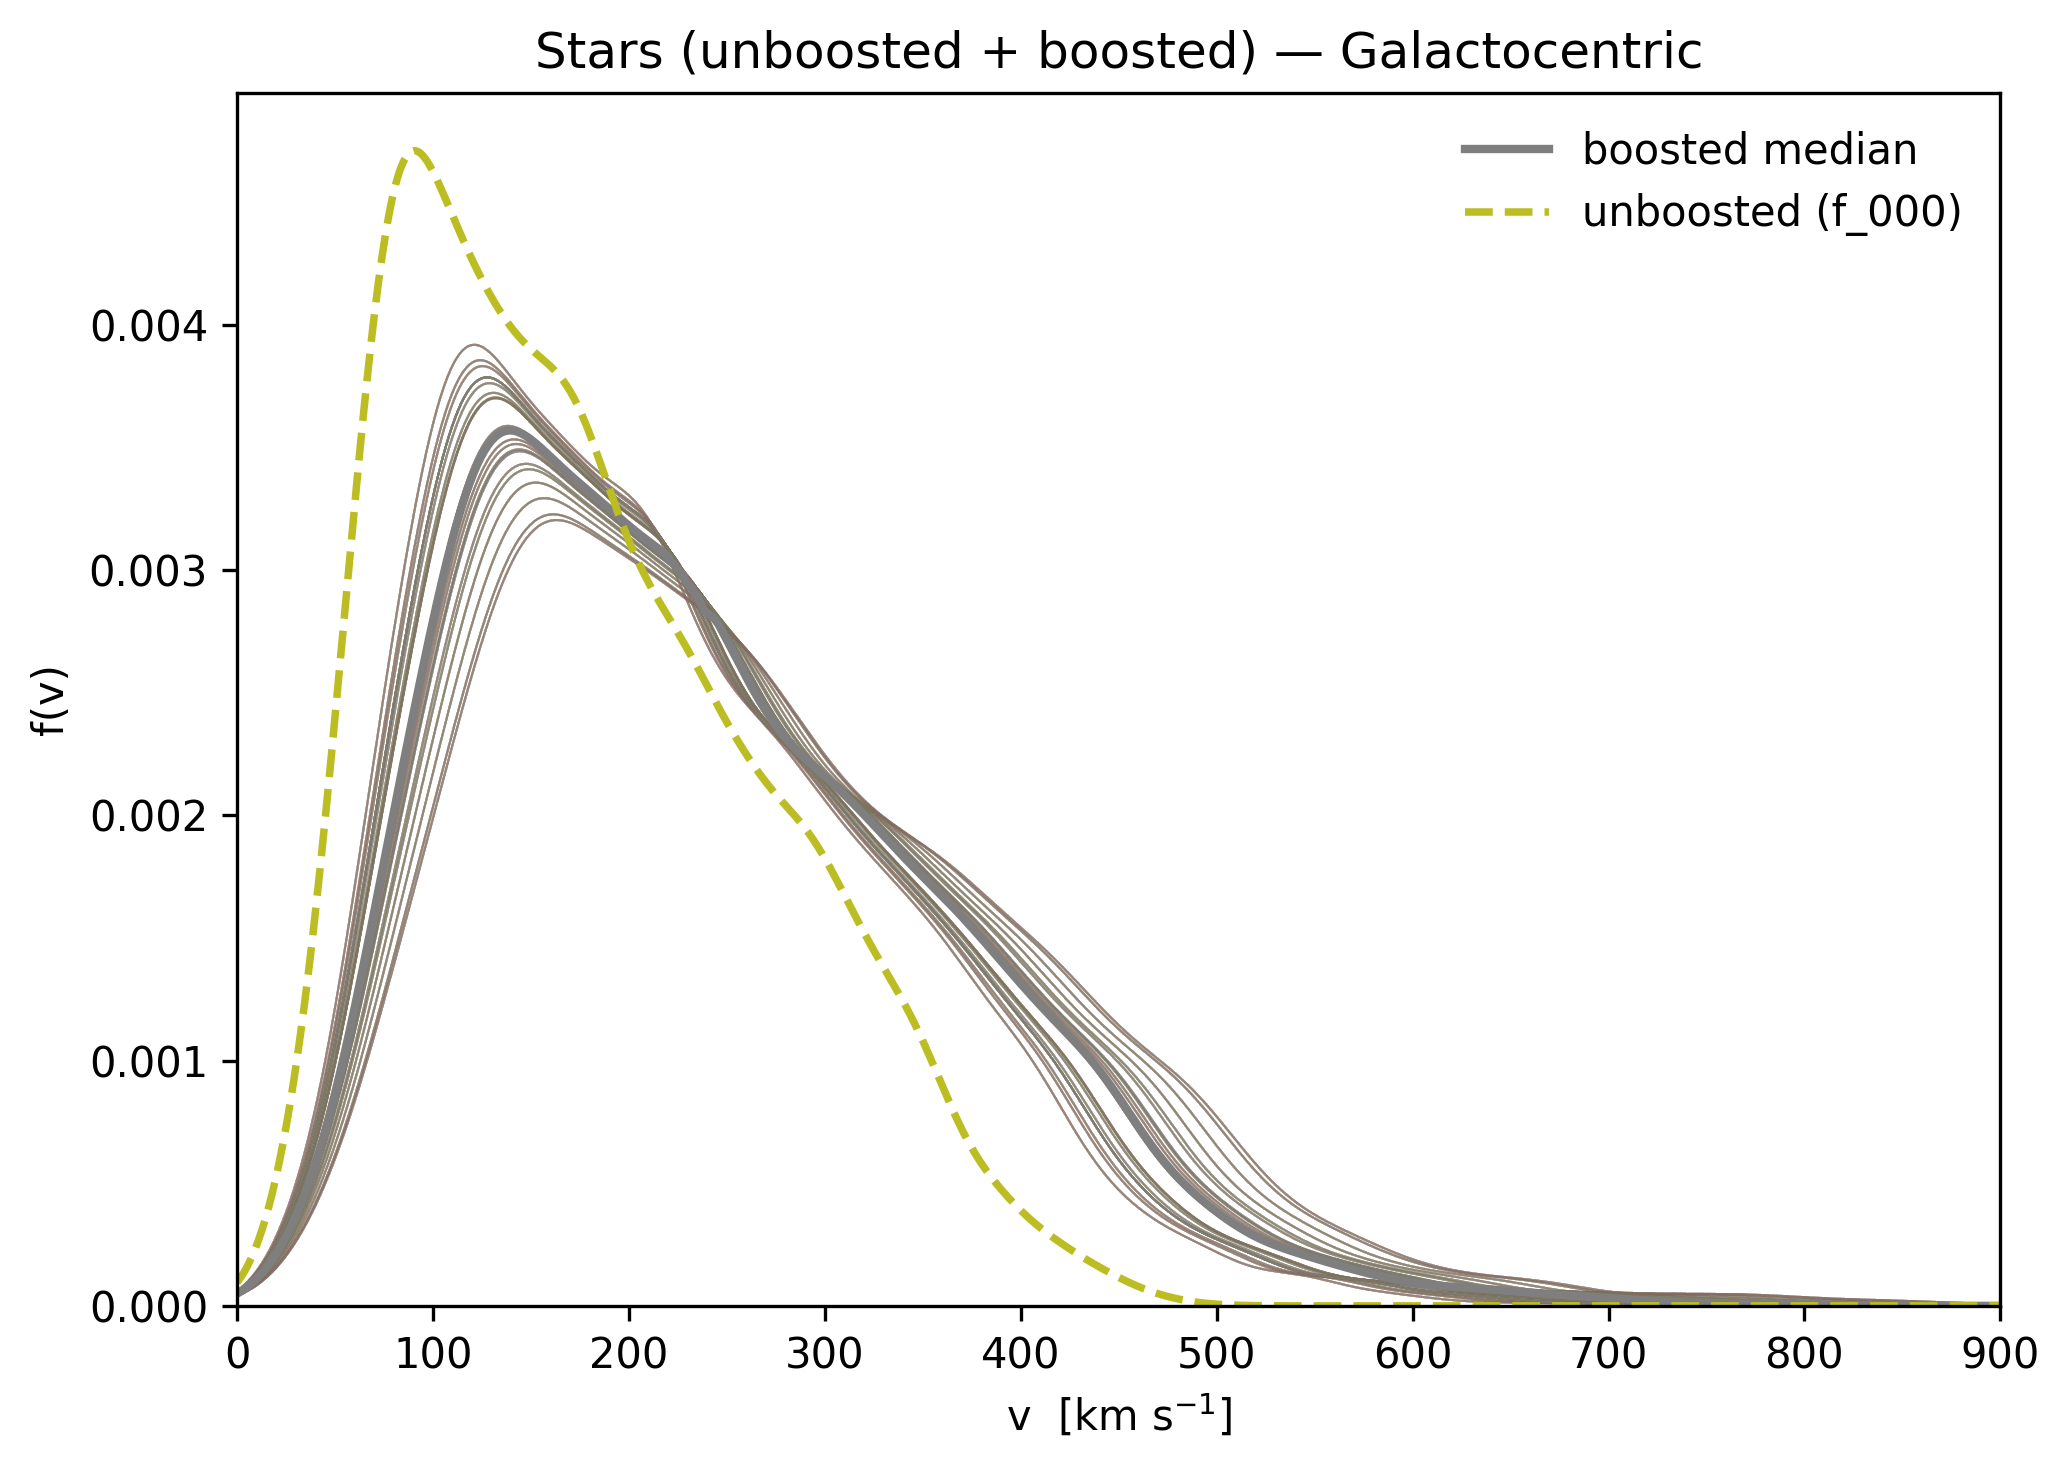

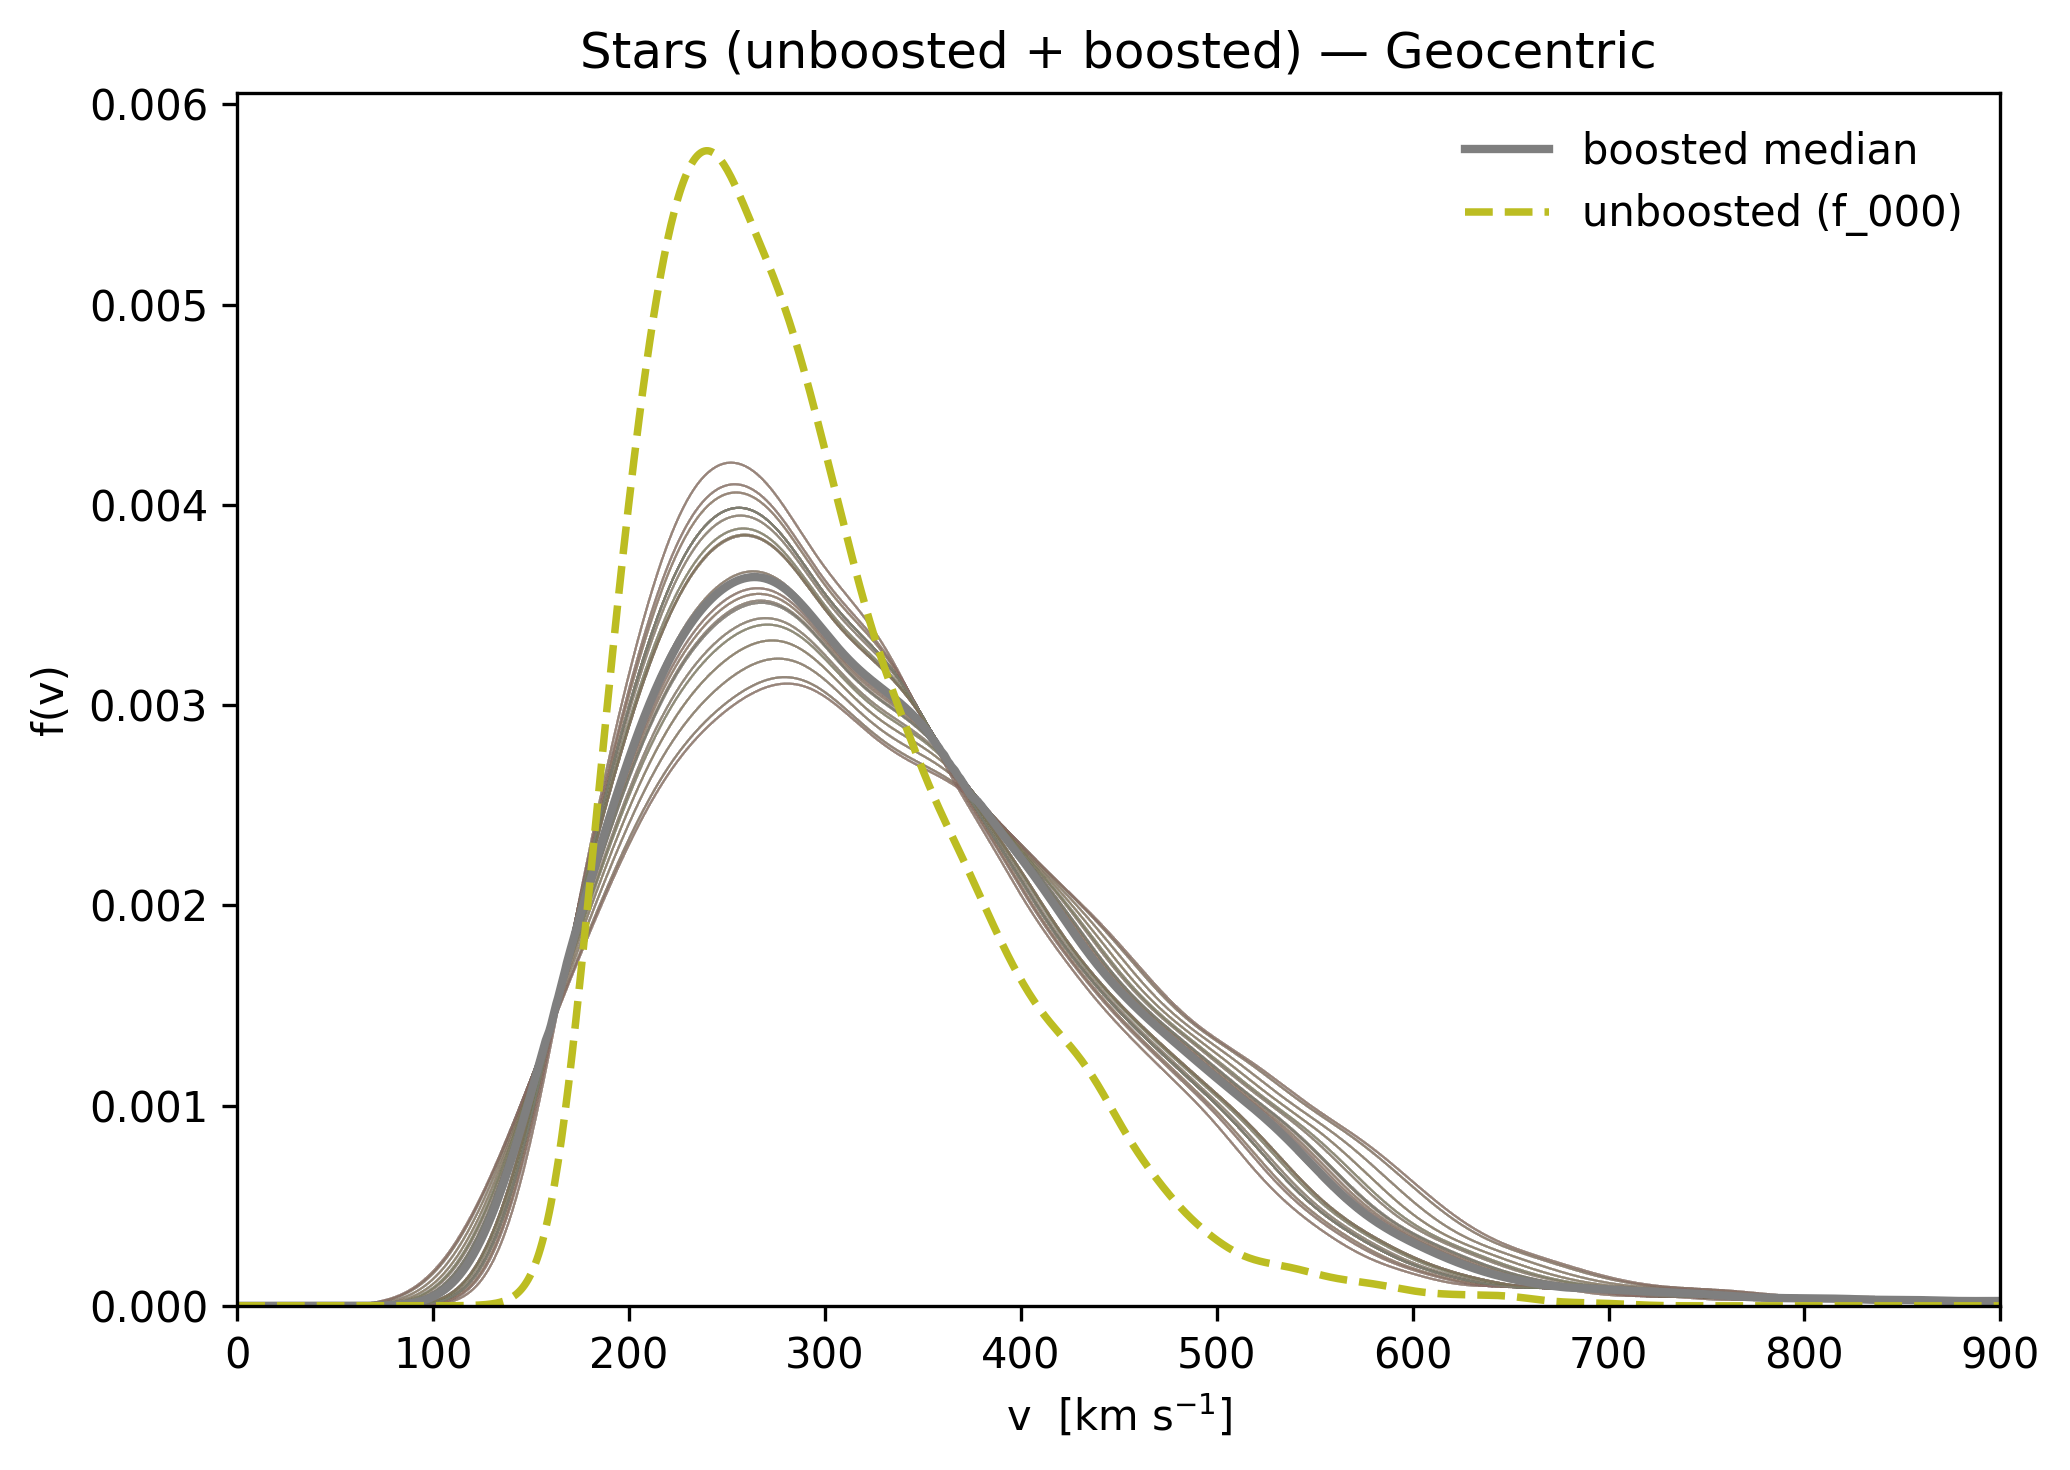

In [5]:
STARS_GAL = "stars_galactocentric.csv"
STARS_GEO = "stars_geocentric.csv"

def load_stars(path):
    # stars files have two parameter rows, then header at row index 2
    df = pd.read_csv(path, header=2)
    v = df["v"].to_numpy(float)
    labels = [c for c in df.columns if c != "v"]        # ['f_000','f_001', ...]
    F = df[labels].to_numpy(float).T                    # [n_cols, Nv]
    # read the two parameter rows
    params = pd.read_csv(path, nrows=2, header=None)
    ds_row = params.iloc[0, 1:1+len(labels)].to_numpy(object)  # delta_sigma
    wt_row = params.iloc[1, 1:1+len(labels)].to_numpy(object)  # w_tr

    y_unboosted = F[0]          # f_000
    Y_boosted   = F[1:]         # f_001.. (aligned 1:1 with totals columns)
    # drop the first (unboosted) entries from params
    ds_aligned = np.array([float(x) for x in ds_row[1:]], dtype=float)
    def _to_float_or_nan(x):
        try: return float(x)
        except: return np.nan
    w_aligned  = np.array([_to_float_or_nan(x) for x in wt_row[1:]], dtype=float)
    return v, y_unboosted, Y_boosted, ds_aligned, w_aligned, labels

def plot_stars_family(v, y_unboosted, Y_boosted, title):
    fig, ax = plt.subplots(figsize=(7,5), dpi=300)
    for y in Y_boosted:
        ax.plot(v, y, lw=0.5, alpha=0.05)
    lo, med, hi = percentile_envelope(Y_boosted, 16, 84, axis=0)
    # ax.fill_between(v, lo, hi, alpha=0.2, lw=0, label="boosted 16–84%")
    ax.plot(v, med, lw=2.0, label="boosted median")
    ax.plot(v, y_unboosted, lw=1.8, ls="--", label="unboosted (f_000)")
    ax.set_xlim(v.min(), v.max()); ax.set_ylim(bottom=0)
    ax.set_xlabel(r"v  [km s$^{-1}$]"); ax.set_ylabel(r"f(v)")
    ax.set_title(title); ax.legend(frameon=False); plt.tight_layout()
    plt.show()

v_s_gal, y0_gal, Yb_gal, ds_gal, wt_gal, _ = load_stars(STARS_GAL)
v_s_geo, y0_geo, Yb_geo, ds_geo, wt_geo, _ = load_stars(STARS_GEO)
assert np.allclose(v_gal, v_s_gal) and np.allclose(v_geo, v_s_geo), "Velocity grids must match."

plot_stars_family(v_s_gal, y0_gal, Yb_gal, "Stars (unboosted + boosted) — Galactocentric")
plot_stars_family(v_s_geo, y0_geo, Yb_geo, "Stars (unboosted + boosted) — Geocentric")
